In [1]:
from functools import partial
from copy import deepcopy
from typing import Dict

import math
import optuna
import networkx as nx
import numpy as np
import pandas as pd
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from sklearn.preprocessing import LabelEncoder
from IPython.core.display import display, HTML
from hyperopt import hp
from optuna.visualization import plot_pareto_front, plot_terminator_improvement
from pyvis.network import Network
from seaborn import color_palette

from examples.synthetic_graph_evolution.generators import postprocess_nx_graph
from golem.core.adapter.nx_adapter import BaseNetworkxAdapter
from golem.core.log import Log
from golem.core.optimisers.objective import Objective, ObjectiveEvaluate
from golem.core.tuning.iopt_tuner import IOptTuner
from golem.core.tuning.optuna_tuner import OptunaTuner
from golem.core.tuning.search_space import SearchSpace
from golem.core.tuning.sequential import SequentialTuner
from golem.core.tuning.simultaneous import SimultaneousTuner



Log().reset_logging_level(50)
optuna.logging.set_verbosity(optuna.logging.WARNING)

d:\repos\AutoMLLabs\lab1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\anato\AppData\Local\Temp\ipykernel_16128\3603119938.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


ModuleNotFoundError: No module named 'golem.core.tuning.iopt_tuner'

# Hyperopt, Optuna примеры

In [ ]:
# define an objective function
def objective(x):
    A = 10
    res = A * len(x)
    for i in x.values():
      res += (i ** 2 - A * math.cos(2 * math.pi * i))
    return res

# define a search space
space = {'x1': hp.uniform('x1', -10, 10),
         'x2': hp.uniform('x2', -10, 10),
         'x3': hp.uniform('x3', -10, 10)}


# minimize the objective over the space
best = fmin(objective, space, algo=tpe.suggest, max_evals=300)
print(best)
objective(best)

100%|██████████| 300/300 [00:03<00:00, 97.02trial/s, best loss: 6.328188812132643]
{'x1': 1.991991405457178, 'x2': -0.9231461014579929, 'x3': 0.042238184962527736}


6.328188812132643

In [ ]:
# define an objective function and search space
def objective(trial):
    x1 = trial.suggest_float('x1', -10, 10)
    x2 = trial.suggest_float('x2', -10, 10)
    x3 = trial.suggest_float('x3', -10, 10)
    x = [x1, x2, x3]
    A = 10
    res = A * len(x)
    for i in x:
      res += (i ** 2 - A * math.cos(2 * math.pi * i))
    return res

# minimize the objective over the space
study = optuna.create_study()
study.optimize(objective, n_trials=300)

print(study.best_params)
study.best_value


{'x1': -0.03344190802621583, 'x2': 0.8894078490368251, 'x3': -0.006785723276748534}


3.3398799161301884

# GOLEM и раскраска графа

Рассмотрим задачу **раскраски графа**.

Суть задачи заключается в том, чтобы каждой вершине графа присвоить некоторый цвет так, чтобы смежные вершины графа имели различные цвета.

Так же постараемся выполнить раскраску минимальным количеством цветов.
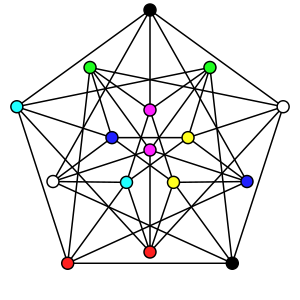

##Зададим оптимизируемую функцию

Для начала нужно сформулировать метрику, относительно которой будет проводиться оптимизация.

In [ ]:
def coloring_errors_count(graph):
  """Количество ошибок в раскраске"""
  objective = 0
  coloring = {node: color for node, color in graph.nodes.data('color')}
  for node in graph.nodes:
    for successor in graph.successors(node):
      if coloring[node] == coloring[successor]:
        objective += 1
  return objective


def colors_count(graph):
  """Количество использованных цветов"""
  coloring = [color for node, color in graph.nodes.data('color')]
  return len(np.unique(coloring))


def coloring_objective(graph: nx.DiGraph):
  """Метрика, объединяющая количество ошибок и количество цветов"""
  objective = coloring_errors_count(graph) + colors_count(graph) / 2
  return objective

In [ ]:
def show_coloring(graph: nx.DiGraph):
  """Отрисовка раскраски графа"""
  nt = Network(height=10, width=10, notebook=True, directed=True)
  coloring = [color for node, color in graph.nodes.data('color')]
  unique_colors = list(set(coloring))
  palette = color_palette('hls', len(unique_colors)).as_hex()
  color_mapping = {color: palette[unique_colors.index(color)] for color in unique_colors}
  for n in graph.nodes:
    nt.add_node(n, label=n, color=color_mapping[graph.nodes[n]['color']])
  for e in graph.edges:
    nt.add_edge(e[0], e[1])
  nt.show(f'{graph.name}.html')
  display(HTML(f'{graph.name}.html'))

## Зададим пространство поиска

В качестве верхней границы количества цветов возьмем максимальную степень вершины данного графа.

Пространство поиска (`search space`) задается для каждой вершины графа отдельно. Каждая вершина графа будет иметь категориальный параметр `color`.

In [ ]:
def init_colors(graph: nx.DiGraph):
    colors = []
    grundy = len(nx.degree_histogram(graph))
    for c in range(grundy):
       colors.append(c)
    return colors


def get_search_space(graph: nx.DiGraph):
  search_space = {}
  node_parameters = {
            'color': {
                'hyperopt-dist': hp.choice,
                'sampling-scope': [init_colors(graph)],
                'type': 'categorical'
            }}
  for node in graph.nodes():
    search_space.update({node: node_parameters})
  return SearchSpace(search_space)

###Простой граф

Рассмотрим работу оптимизатора на примере простого графа.

In [ ]:
graph = nx.DiGraph()
for i in range(4):
  graph.add_node(str(i), name=str(i), color=0)
graph.add_edges_from([('0', '1'), ('2', '1'), ('2', '0'), ('2', '3')])

In [ ]:
show_coloring(graph)

Метрика для этого графа будет равна 4.5 - 4 ошибки в раскраске и 1 использованный цвет.

In [ ]:
coloring_objective(graph)

4.5

Запустим тюнер и посмотрим на результат.

In [ ]:
def get_objective_evaluate(objectives: Dict, is_multi_objective: bool = False):
  return ObjectiveEvaluate(Objective(objectives, is_multi_objective=is_multi_objective))

In [ ]:

tuner = SimultaneousTuner(get_objective_evaluate(coloring_objective), get_search_space(graph), BaseNetworkxAdapter(), iterations=20)
tuned_graph = tuner.tune(graph, show_progress=True)

100%|██████████| 20/20 [00:00<00:00, 362.01trial/s, best loss: 1.5]


In [ ]:
show_coloring(tuned_graph)

##Раскраска случайного графа

In [ ]:
def generate_initial_graph(size: int):
  graph = nx.gnp_random_graph(size, p=0.1)
  graph = postprocess_nx_graph(graph,
                               node_labels = [str(i) for i in range(size)],
                               connected= True,
                               directed= True)
  nx.set_node_attributes(graph, 0, 'color')
  mapping = {i: str(i) for i in range(size)}
  graph = nx.relabel_nodes(graph, mapping)
  return graph

In [ ]:
graph = generate_initial_graph(30)
show_coloring(graph)

In [ ]:
def run_coloring(graph, tuner_cls, iterations=30, objectives=None, is_multi_objective=False):
  objectives = objectives or {'coloring_metric': coloring_objective}
  tuner = tuner_cls(get_objective_evaluate(objectives, is_multi_objective),
                    get_search_space(graph),
                    BaseNetworkxAdapter(),
                    iterations)
  tuned_graphs = tuner.tune(deepcopy(graph))
  tuned_graphs = tuned_graphs if isinstance(tuned_graphs, list) else [tuned_graphs]

  for graph in tuned_graphs:
    print(f'Number of coloring errors: {coloring_errors_count(graph)}\n',
          f'Number of colors: {colors_count(graph)}')
  show_coloring(tuned_graphs[-1])
  return tuned_graphs, tuner

### Тюнеры на основе Hyperopt

`SimultaneousTuner` оптимизирует параметы во всем графе одновременно.

In [ ]:
tuned_graph, _ = run_coloring(deepcopy(graph), SimultaneousTuner, iterations=300)

 73%|███████▎  | 218/300 [00:14<00:05, 15.07trial/s, best loss: 5.0]
Number of coloring errors: 1
 Number of colors: 8


`SequentialTuner` оптимизирует параметры вершин графа последовательно проходя по графу.

In [ ]:
tuned_graph, _ = run_coloring(deepcopy(graph), SequentialTuner, iterations=300)

100%|██████████| 10/10 [00:00<00:00, 591.75trial/s, best loss: 3.0]
Number of coloring errors: 0
 Number of colors: 6


### Тюнер на основе Optuna

`OptunaTuner`, как и ранее рассмотренные оптимизаторы, производит однокритериальную оптимизацию.

In [ ]:
tuned_graph, _ = run_coloring(deepcopy(graph), OptunaTuner, iterations=300)

  0%|          | 0/300 [00:00<?, ?it/s]

[I 2023-08-30 14:17:22,589] Trial 0 finished with value: 54.5 and parameters: {'0 || 23 | color': 0, '1 || 22 | color': 0, '2 || 12 | color': 0, '3 || 25 | color': 0, '4 || 0 | color': 0, '5 || 7 | color': 0, '6 || 27 | color': 0, '7 || 17 | color': 0, '8 || 18 | color': 0, '9 || 14 | color': 0, '10 || 4 | color': 0, '11 || 4 | color': 0, '12 || 0 | color': 0, '13 || 9 | color': 0, '14 || 6 | color': 0, '15 || 18 | color': 0, '17 || 23 | color': 0, '18 || 21 | color': 0, '19 || 18 | color': 0, '20 || 19 | color': 0, '21 || 27 | color': 0, '22 || 9 | color': 0, '23 || 6 | color': 0, '24 || 13 | color': 0, '25 || 20 | color': 0, '26 || 12 | color': 0, '27 || 17 | color': 0}. Best is trial 0 with value: 54.5.
[I 2023-08-30 14:17:22,620] Trial 1 finished with value: 8.0 and parameters: {'0 || 23 | color': 2, '1 || 22 | color': 5, '2 || 12 | color': 6, '3 || 25 | color': 4, '4 || 0 | color': 0, '5 || 7 | color': 5, '6 || 27 | color': 4, '7 || 17 | color': 6, '8 || 18 | color': 5, '9 || 14 |

Однако, данную задачу можно сформулировать и как **многокритериальную**.

Минимизируем одновременно две метрики: число ошибок в раскраске и число использованных цветов.

In [ ]:
tuned_graphs, tuner = run_coloring(deepcopy(graph),
                           partial(OptunaTuner, objectives_number=2),
                           objectives={'errors_count': coloring_errors_count, 'colors_count': colors_count},
                           iterations=300,
                           is_multi_objective=True)


[I 2023-08-30 14:18:17,284] A new study created in memory with name: no-name-1cd6ff6f-e6a5-4268-82d8-f6c537c28f37


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2023-08-30 14:18:17,315] Trial 0 finished with values: [54.0, 1.0] and parameters: {'0 || 23 | color': 0, '1 || 22 | color': 0, '2 || 12 | color': 0, '3 || 25 | color': 0, '4 || 0 | color': 0, '5 || 7 | color': 0, '6 || 27 | color': 0, '7 || 17 | color': 0, '8 || 18 | color': 0, '9 || 14 | color': 0, '10 || 4 | color': 0, '11 || 4 | color': 0, '12 || 0 | color': 0, '13 || 9 | color': 0, '14 || 6 | color': 0, '15 || 18 | color': 0, '17 || 23 | color': 0, '18 || 21 | color': 0, '19 || 18 | color': 0, '20 || 19 | color': 0, '21 || 27 | color': 0, '22 || 9 | color': 0, '23 || 6 | color': 0, '24 || 13 | color': 0, '25 || 20 | color': 0, '26 || 12 | color': 0, '27 || 17 | color': 0}. 
[I 2023-08-30 14:18:17,351] Trial 2 finished with values: [12.0, 8.0] and parameters: {'0 || 23 | color': 1, '1 || 22 | color': 3, '2 || 12 | color': 3, '3 || 25 | color': 7, '4 || 0 | color': 7, '5 || 7 | color': 1, '6 || 27 | color': 4, '7 || 17 | color': 6, '8 || 18 | color': 5, '9 || 14 | color': 0, '10 

Ниже представлен фронт парето полученных раскрасок

In [ ]:
plot_pareto_front(tuner.study, target_names=['errors num.', 'colors num.'])

Запустим многокритериальную оптимизацию, используя один из ранее полученных графов как начальное приближение.

In [ ]:
tuned_graphs, tuner = run_coloring(deepcopy(tuned_graphs[-1]),
                           partial(OptunaTuner, objectives_number=2),
                           objectives={'errors_count': coloring_errors_count, 'colors_count': colors_count},
                           iterations=300,
                           is_multi_objective=True)

[I 2023-08-30 14:18:23,181] A new study created in memory with name: no-name-9ba1c656-0661-4ed6-8ccc-9ca421739c06


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2023-08-30 14:18:23,210] Trial 0 finished with values: [0.0, 8.0] and parameters: {'0 || 23 | color': 6, '1 || 22 | color': 2, '2 || 12 | color': 6, '3 || 25 | color': 0, '4 || 0 | color': 3, '5 || 7 | color': 0, '6 || 27 | color': 2, '7 || 17 | color': 6, '8 || 18 | color': 5, '9 || 14 | color': 2, '10 || 4 | color': 6, '11 || 4 | color': 5, '12 || 0 | color': 3, '13 || 9 | color': 2, '14 || 6 | color': 4, '15 || 18 | color': 6, '17 || 23 | color': 7, '18 || 21 | color': 2, '19 || 18 | color': 4, '20 || 19 | color': 5, '21 || 27 | color': 5, '22 || 9 | color': 7, '23 || 6 | color': 6, '24 || 13 | color': 4, '25 || 20 | color': 3, '26 || 12 | color': 3, '27 || 17 | color': 1}. 
[I 2023-08-30 14:18:23,229] Trial 1 finished with values: [9.0, 8.0] and parameters: {'0 || 23 | color': 0, '1 || 22 | color': 0, '2 || 12 | color': 7, '3 || 25 | color': 0, '4 || 0 | color': 2, '5 || 7 | color': 4, '6 || 27 | color': 1, '7 || 17 | color': 7, '8 || 18 | color': 4, '9 || 14 | color': 4, '10 ||

In [ ]:
plot_pareto_front(tuner.study, target_names=['errors num.', 'colors num.'])

# FEDOT и тюнинг гиперпараметров композитных моделей машинного обучения

Для примера воспользуемся датасетом **Sloan Digital Sky Survey - DR18**

https://www.kaggle.com/datasets/diraf0/sloan-digital-sky-survey-dr18

Будем решать задачу многоклассовой классификации.

In [ ]:
!gdown --id 17OpMtaNUpxuSLYmlB1Obyxu8jwwbqkiL

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17OpMtaNUpxuSLYmlB1Obyxu8jwwbqkiL
To: /content/cropped_SDSS_DR18.csv
100% 337k/337k [00:00<00:00, 118MB/s]


In [ ]:

from examples.simple.classification.classification_pipelines import classification_random_forest_pipeline
from fedot.core.data.data import InputData
from fedot.core.repository.tasks import Task, TaskTypesEnum
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot.core.composer.metrics import F1
from fedot.core.optimisers.objective import MetricsObjective, PipelineObjectiveEvaluate
from fedot.core.optimisers.objective.data_source_splitter import DataSourceSplitter
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import ClassificationMetricsEnum
from fedot.core.repository.dataset_types import DataTypesEnum

In [ ]:
df = pd.read_csv('/content/cropped_SDSS_DR18.csv')
le = LabelEncoder()
X = df.drop('class', axis=1)
Y = le.fit_transform(df['class'])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.3, random_state=42)

In [ ]:
train_data = InputData(idx=list(X_train.index),
                       features=X_train.values,
                       target=y_train,
                       task=Task(TaskTypesEnum.classification),
                       data_type=DataTypesEnum.table)

test_data = InputData(idx=range(len(X_test)),
                       features=X_test.values,
                       target=y_test,
                       task=Task(TaskTypesEnum.classification),
                       data_type=DataTypesEnum.table)

В качестве модели возьмем пайплайн состоящий из standart scaling и random forest.

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning:

The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning:

The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning:

The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning:

The inverse_squared link alias is deprecated. Use InverseSquared instead. The inverse_squared link alias will be removed after the 0.15.0 release.



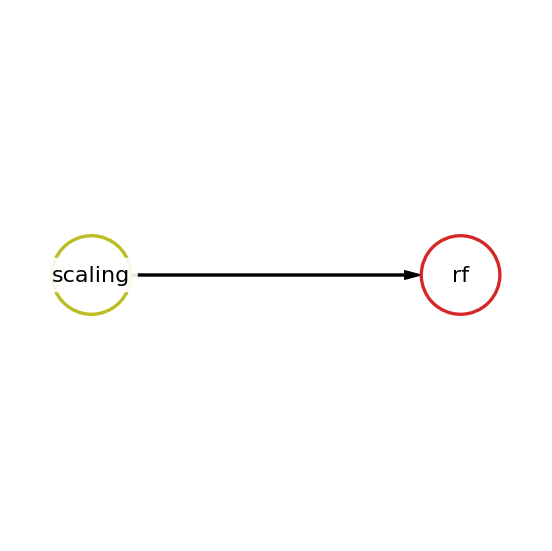

In [ ]:
pipeline = PipelineBuilder().add_sequence('scaling', 'rf').build()

pipeline.show(dpi=80)

## Однокритериальная оптимизация

In [ ]:
hyperopt_tuner = (TunerBuilder(Task(TaskTypesEnum.classification))
                  .with_tuner(SimultaneousTuner)
                  .with_cv_folds(3)
                  .with_n_jobs(-1)
                  .with_metric(ClassificationMetricsEnum.f1)
                  .with_iterations(30)
                  .build(train_data))

In [ ]:
hyperopt_pipeline = hyperopt_tuner.tune(deepcopy(pipeline))

100%|██████████| 30/30 [00:28<00:00,  1.04trial/s, best loss: -0.9898816024478169]


In [ ]:
optuna_tuner = (TunerBuilder(Task(TaskTypesEnum.classification))
                .with_tuner(OptunaTuner)
                .with_cv_folds(5)
                .with_n_jobs(-1)
                .with_metric(ClassificationMetricsEnum.f1)
                .with_iterations(30)
                .build(train_data))

In [ ]:
optuna_pipeline = optuna_tuner.tune(deepcopy(pipeline))

[I 2023-08-30 14:19:18,402] A new study created in memory with name: no-name-8315a77e-e1cd-49a6-838d-e69b8efe0fe3


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-08-30 14:19:20,970] Trial 1 finished with value: -0.9622579752693781 and parameters: {'0 || rf | criterion': 'gini', '0 || rf | max_features': 0.3503969356624154, '0 || rf | min_samples_split': 8, '0 || rf | min_samples_leaf': 6, '0 || rf | bootstrap': True}. Best is trial 1 with value: -0.9622579752693781.
[I 2023-08-30 14:19:22,261] Trial 0 finished with value: -0.9792130832130832 and parameters: {'0 || rf | criterion': 'entropy', '0 || rf | max_features': 0.758758193033915, '0 || rf | min_samples_split': 2, '0 || rf | min_samples_leaf': 13, '0 || rf | bootstrap': False}. Best is trial 0 with value: -0.9792130832130832.
[I 2023-08-30 14:19:25,558] Trial 3 finished with value: -0.9074011257887186 and parameters: {'0 || rf | criterion': 'entropy', '0 || rf | max_features': 0.09614868116134777, '0 || rf | min_samples_split': 10, '0 || rf | min_samples_leaf': 14, '0 || rf | bootstrap': False}. Best is trial 0 with value: -0.9792130832130832.
[I 2023-08-30 14:19:26,247] Trial 2 fi

In [ ]:
fig = optuna.visualization.plot_param_importances(optuna_tuner.study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_optimization_history(optuna_tuner.study)
fig.show()

## Многокритериальная оптимизация

In [ ]:
optuna_multiobj_tuner = (TunerBuilder(Task(TaskTypesEnum.classification))
                         .with_tuner(OptunaTuner)
                         .with_cv_folds(5)
                         .with_n_jobs(-1)
                         .with_metric(metrics = [ClassificationMetricsEnum.f1, ClassificationMetricsEnum.ROCAUC])
                         .with_iterations(30)
                         .build(train_data))

In [ ]:
optuna_multiobj_pipeline = optuna_multiobj_tuner.tune(deepcopy(pipeline))

[I 2023-08-30 14:20:15,189] A new study created in memory with name: no-name-f42dc538-c97f-41a6-b8df-eb4381962a63


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-08-30 14:20:20,229] Trial 1 finished with values: [-0.9897840366498902, -0.9996] and parameters: {'0 || rf | criterion': 'gini', '0 || rf | max_features': 0.7573054640674858, '0 || rf | min_samples_split': 4, '0 || rf | min_samples_leaf': 5, '0 || rf | bootstrap': True}. 
[I 2023-08-30 14:20:20,533] Trial 0 finished with values: [-0.9789617487300413, -0.9992000000000001] and parameters: {'0 || rf | criterion': 'entropy', '0 || rf | max_features': 0.49613595618430717, '0 || rf | min_samples_split': 3, '0 || rf | min_samples_leaf': 10, '0 || rf | bootstrap': False}. 
[I 2023-08-30 14:20:24,169] Trial 2 finished with values: [-0.9725071892124998, -0.9992000000000001] and parameters: {'0 || rf | criterion': 'entropy', '0 || rf | max_features': 0.2310529821265775, '0 || rf | min_samples_split': 6, '0 || rf | min_samples_leaf': 3, '0 || rf | bootstrap': False}. 
[I 2023-08-30 14:20:25,773] Trial 3 finished with values: [-0.9792130832130832, -0.9987999999999999] and parameters: {'0 ||

In [ ]:
plot_pareto_front(optuna_multiobj_tuner.study, target_names=['f1', 'ROCAUC'])

## Кастомная метрика

In [ ]:
import sys
from fedot.core.composer.metrics import QualityMetric
from fedot.core.data.data import InputData, OutputData
from sklearn.metrics import accuracy_score


class CustomMetric(QualityMetric):
    default_value = 0
    output_mode = 'labels'

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        acc_value = accuracy_score(reference.target, predicted.predict)
        return -(acc_value + 2) * 0.5

In [ ]:
optuna_tuner = (TunerBuilder(Task(TaskTypesEnum.classification))
                  .with_tuner(OptunaTuner)
                  .with_cv_folds(5)
                  .with_n_jobs(-1)
                  .with_metric(CustomMetric.get_value)
                  .with_iterations(20)
                  .build(train_data))

In [ ]:
optuna_pipeline = optuna_tuner.tune(deepcopy(pipeline))

[I 2023-08-30 14:21:19,416] A new study created in memory with name: no-name-b632d181-2e9c-43b6-a594-5d245ac40a1d


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-08-30 14:21:22,494] Trial 0 finished with value: -1.4783333333333335 and parameters: {'0 || rf | criterion': 'entropy', '0 || rf | max_features': 0.25669550340460545, '0 || rf | min_samples_split': 5, '0 || rf | min_samples_leaf': 6, '0 || rf | bootstrap': True}. Best is trial 0 with value: -1.4783333333333335.
[I 2023-08-30 14:21:22,654] Trial 1 finished with value: -1.4949999999999999 and parameters: {'0 || rf | criterion': 'gini', '0 || rf | max_features': 0.8929419569240651, '0 || rf | min_samples_split': 8, '0 || rf | min_samples_leaf': 1, '0 || rf | bootstrap': True}. Best is trial 1 with value: -1.4949999999999999.
[I 2023-08-30 14:21:25,378] Trial 3 finished with value: -1.4833333333333334 and parameters: {'0 || rf | criterion': 'entropy', '0 || rf | max_features': 0.3460895949689613, '0 || rf | min_samples_split': 10, '0 || rf | min_samples_leaf': 9, '0 || rf | bootstrap': True}. Best is trial 1 with value: -1.4949999999999999.
[I 2023-08-30 14:21:25,639] Trial 2 finis

## Кастомное пространство поиска

In [ ]:
from fedot.core.pipelines.tuning.search_space import PipelineSearchSpace

custom_search_space = {'rf': {
                              'criterion': {
                                  'hyperopt-dist': hp.choice,
                                  'sampling-scope': [["gini", "entropy", "log_loss"]],
                                  'type': 'categorical'},

                              'max_features': {
                                  'hyperopt-dist': hp.uniform,
                                  'sampling-scope': [0.2, 1.0],
                                  'type': 'continuous'},

                              'min_samples_split': {
                                  'hyperopt-dist': hp.uniformint,
                                  'sampling-scope': [10, 20],
                                  'type': 'discrete'},

                              'min_samples_leaf': {
                                  'hyperopt-dist': hp.uniformint,
                                  'sampling-scope': [5, 15],
                                  'type': 'discrete'},

                              'bootstrap': {
                                  'hyperopt-dist': hp.choice,
                                  'sampling-scope': [[True, False]],
                                  'type': 'categorical'}}
}

search_space = PipelineSearchSpace(custom_search_space=custom_search_space, replace_default_search_space=True)

In [ ]:
optuna_tuner = (TunerBuilder(Task(TaskTypesEnum.classification))
                  .with_tuner(OptunaTuner)
                  .with_cv_folds(5)
                  .with_n_jobs(-1)
                  .with_iterations(30)
                  .with_metric(ClassificationMetricsEnum.f1)
                  .with_search_space(search_space)
                  .build(train_data))

In [ ]:
tuned_pipeline = optuna_tuner.tune(deepcopy(pipeline))

[I 2023-08-30 14:21:57,399] A new study created in memory with name: no-name-547108c5-85cc-41b3-9421-8a0202d01ef7


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-08-30 14:22:00,509] Trial 1 finished with value: -0.9690023799668708 and parameters: {'0 || rf | criterion': 'entropy', '0 || rf | max_features': 0.4461858615607035, '0 || rf | min_samples_split': 18, '0 || rf | min_samples_leaf': 14, '0 || rf | bootstrap': False}. Best is trial 1 with value: -0.9690023799668708.
[I 2023-08-30 14:22:00,562] Trial 0 finished with value: -0.9863042778212943 and parameters: {'0 || rf | criterion': 'entropy', '0 || rf | max_features': 0.81609734577112, '0 || rf | min_samples_split': 12, '0 || rf | min_samples_leaf': 6, '0 || rf | bootstrap': True}. Best is trial 0 with value: -0.9863042778212943.
[I 2023-08-30 14:22:03,869] Trial 2 finished with value: -0.9693067742097593 and parameters: {'0 || rf | criterion': 'gini', '0 || rf | max_features': 0.4444179450608185, '0 || rf | min_samples_split': 12, '0 || rf | min_samples_leaf': 13, '0 || rf | bootstrap': False}. Best is trial 0 with value: -0.9863042778212943.
[I 2023-08-30 14:22:04,116] Trial 3 fi